### IMPORTS

In [19]:
import matplotlib.pyplot as plt
from utils.plot import plot_arrow
import sys
import pathlib

from math import sin, cos, atan2, sqrt, acos, pi, hypot
import numpy as np
from utils.angle import angle_mod, rot_mat_2d

import matplotlib.patches as patches
from coppeliasim_zmqremoteapi_client import RemoteAPIClient
from scipy.spatial.distance import euclidean
from scipy.optimize import linear_sum_assignment
from scipy.spatial import distance_matrix
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
import math


import random

### DUBINS

In [20]:
"""

Dubins path planner sample code

author Atsushi Sakai(@Atsushi_twi)

"""

def plan_dubins_path(s_x, s_y, s_yaw, g_x, g_y, g_yaw, curvature,
                     step_size=0.1, selected_types=None):
    """
    Plan dubins path

    Parameters
    ----------
    s_x : float
        x position of the start point [m]
    s_y : float
        y position of the start point [m]
    s_yaw : float
        yaw angle of the start point [rad]
    g_x : float
        x position of the goal point [m]
    g_y : float
        y position of the end point [m]
    g_yaw : float
        yaw angle of the end point [rad]
    curvature : float
        curvature for curve [1/m]
    step_size : float (optional)
        step size between two path points [m]. Default is 0.1
    selected_types : a list of string or None
        selected path planning types. If None, all types are used for
        path planning, and minimum path length result is returned.
        You can select used path plannings types by a string list.
        e.g.: ["RSL", "RSR"]

    Returns
    -------
    x_list: array
        x positions of the path
    y_list: array
        y positions of the path
    yaw_list: array
        yaw angles of the path
    modes: array
        mode list of the path
    lengths: array
        arrow_length list of the path segments.

    Examples
    --------
    You can generate a dubins path.

    >>> start_x = 1.0  # [m]
    >>> start_y = 1.0  # [m]
    >>> start_yaw = np.deg2rad(45.0)  # [rad]
    >>> end_x = -3.0  # [m]
    >>> end_y = -3.0  # [m]
    >>> end_yaw = np.deg2rad(-45.0)  # [rad]
    >>> curvature = 1.0
    >>> path_x, path_y, path_yaw, mode, _ = plan_dubins_path(
                start_x, start_y, start_yaw, end_x, end_y, end_yaw, curvature)
    >>> plt.plot(path_x, path_y, label="final course " + "".join(mode))
    >>> plot_arrow(start_x, start_y, start_yaw)
    >>> plot_arrow(end_x, end_y, end_yaw)
    >>> plt.legend()
    >>> plt.grid(True)
    >>> plt.axis("equal")
    >>> plt.show()

    .. image:: dubins_path.jpg
    """
    if selected_types is None:
        planning_funcs = _PATH_TYPE_MAP.values()
    else:
        planning_funcs = [_PATH_TYPE_MAP[ptype] for ptype in selected_types]

    # calculate local goal x, y, yaw
    l_rot = rot_mat_2d(s_yaw)
    le_xy = np.stack([g_x - s_x, g_y - s_y]).T @ l_rot
    local_goal_x = le_xy[0]
    local_goal_y = le_xy[1]
    local_goal_yaw = g_yaw - s_yaw

    lp_x, lp_y, lp_yaw, modes, lengths = _dubins_path_planning_from_origin(
        local_goal_x, local_goal_y, local_goal_yaw, curvature, step_size,
        planning_funcs)

    # Convert a local coordinate path to the global coordinate
    rot = rot_mat_2d(-s_yaw)
    converted_xy = np.stack([lp_x, lp_y]).T @ rot
    x_list = converted_xy[:, 0] + s_x
    y_list = converted_xy[:, 1] + s_y
    yaw_list = angle_mod(np.array(lp_yaw) + s_yaw)

    return x_list, y_list, yaw_list, modes, lengths


def _mod2pi(theta):
    return angle_mod(theta, zero_2_2pi=True)


def _calc_trig_funcs(alpha, beta):
    sin_a = sin(alpha)
    sin_b = sin(beta)
    cos_a = cos(alpha)
    cos_b = cos(beta)
    cos_ab = cos(alpha - beta)
    return sin_a, sin_b, cos_a, cos_b, cos_ab


def _LSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "S", "L"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_a - sin_b))
    if p_squared < 0:  # invalid configuration
        return None, None, None, mode
    tmp = atan2((cos_b - cos_a), d + sin_a - sin_b)
    d1 = _mod2pi(-alpha + tmp)
    d2 = sqrt(p_squared)
    d3 = _mod2pi(beta - tmp)
    return d1, d2, d3, mode


def _RSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "S", "R"]
    p_squared = 2 + d ** 2 - (2 * cos_ab) + (2 * d * (sin_b - sin_a))
    if p_squared < 0:
        return None, None, None, mode
    tmp = atan2((cos_a - cos_b), d - sin_a + sin_b)
    d1 = _mod2pi(alpha - tmp)
    d2 = sqrt(p_squared)
    d3 = _mod2pi(-beta + tmp)
    return d1, d2, d3, mode


def _LSR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = -2 + d ** 2 + (2 * cos_ab) + (2 * d * (sin_a + sin_b))
    mode = ["L", "S", "R"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = sqrt(p_squared)
    tmp = atan2((-cos_a - cos_b), (d + sin_a + sin_b)) - atan2(-2.0, d1)
    d2 = _mod2pi(-alpha + tmp)
    d3 = _mod2pi(-_mod2pi(beta) + tmp)
    return d2, d1, d3, mode


def _RSL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    p_squared = d ** 2 - 2 + (2 * cos_ab) - (2 * d * (sin_a + sin_b))
    mode = ["R", "S", "L"]
    if p_squared < 0:
        return None, None, None, mode
    d1 = sqrt(p_squared)
    tmp = atan2((cos_a + cos_b), (d - sin_a - sin_b)) - atan2(2.0, d1)
    d2 = _mod2pi(alpha - tmp)
    d3 = _mod2pi(beta - tmp)
    return d2, d1, d3, mode


def _RLR(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["R", "L", "R"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (sin_a - sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * pi - acos(tmp))
    d1 = _mod2pi(alpha - atan2(cos_a - cos_b, d - sin_a + sin_b) + d2 / 2.0)
    d3 = _mod2pi(alpha - beta - d1 + d2)
    return d1, d2, d3, mode


def _LRL(alpha, beta, d):
    sin_a, sin_b, cos_a, cos_b, cos_ab = _calc_trig_funcs(alpha, beta)
    mode = ["L", "R", "L"]
    tmp = (6.0 - d ** 2 + 2.0 * cos_ab + 2.0 * d * (- sin_a + sin_b)) / 8.0
    if abs(tmp) > 1.0:
        return None, None, None, mode
    d2 = _mod2pi(2 * pi - acos(tmp))
    d1 = _mod2pi(-alpha - atan2(cos_a - cos_b, d + sin_a - sin_b) + d2 / 2.0)
    d3 = _mod2pi(_mod2pi(beta) - alpha - d1 + _mod2pi(d2))
    return d1, d2, d3, mode


_PATH_TYPE_MAP = {"LSL": _LSL, "RSR": _RSR, "LSR": _LSR, "RSL": _RSL,
                  "RLR": _RLR, "LRL": _LRL, }


def _dubins_path_planning_from_origin(end_x, end_y, end_yaw, curvature,
                                      step_size, planning_funcs):
    dx = end_x
    dy = end_y
    d = hypot(dx, dy) * curvature

    theta = _mod2pi(atan2(dy, dx))
    alpha = _mod2pi(-theta)
    beta = _mod2pi(end_yaw - theta)

    best_cost = float("inf")
    b_d1, b_d2, b_d3, b_mode = None, None, None, None

    for planner in planning_funcs:
        d1, d2, d3, mode = planner(alpha, beta, d)
        if d1 is None:
            continue

        cost = (abs(d1) + abs(d2) + abs(d3))
        if best_cost > cost:  # Select minimum length one.
            b_d1, b_d2, b_d3, b_mode, best_cost = d1, d2, d3, mode, cost

    lengths = [b_d1, b_d2, b_d3]
    x_list, y_list, yaw_list = _generate_local_course(lengths, b_mode,
                                                      curvature, step_size)

    lengths = [length / curvature for length in lengths]

    return x_list, y_list, yaw_list, b_mode, lengths


def _interpolate(length, mode, max_curvature, origin_x, origin_y,
                 origin_yaw, path_x, path_y, path_yaw):
    if mode == "S":
        path_x.append(origin_x + length / max_curvature * cos(origin_yaw))
        path_y.append(origin_y + length / max_curvature * sin(origin_yaw))
        path_yaw.append(origin_yaw)
    else:  # curve
        ldx = sin(length) / max_curvature
        ldy = 0.0
        if mode == "L":  # left turn
            ldy = (1.0 - cos(length)) / max_curvature
        elif mode == "R":  # right turn
            ldy = (1.0 - cos(length)) / -max_curvature
        gdx = cos(-origin_yaw) * ldx + sin(-origin_yaw) * ldy
        gdy = -sin(-origin_yaw) * ldx + cos(-origin_yaw) * ldy
        path_x.append(origin_x + gdx)
        path_y.append(origin_y + gdy)

        if mode == "L":  # left turn
            path_yaw.append(origin_yaw + length)
        elif mode == "R":  # right turn
            path_yaw.append(origin_yaw - length)

    return path_x, path_y, path_yaw


def _generate_local_course(lengths, modes, max_curvature, step_size):
    p_x, p_y, p_yaw = [0.0], [0.0], [0.0]

    for (mode, length) in zip(modes, lengths):
        if length == 0.0:
            continue

        # set origin state
        origin_x, origin_y, origin_yaw = p_x[-1], p_y[-1], p_yaw[-1]

        current_length = step_size
        while abs(current_length + step_size) <= abs(length):
            p_x, p_y, p_yaw = _interpolate(current_length, mode, max_curvature,
                                           origin_x, origin_y, origin_yaw,
                                           p_x, p_y, p_yaw)
            current_length += step_size

        p_x, p_y, p_yaw = _interpolate(length, mode, max_curvature, origin_x,
                                       origin_y, origin_yaw, p_x, p_y, p_yaw)

    return p_x, p_y, p_yaw

### TSP

In [21]:
def mean_angle(v1, v2):
    angle1 = math.atan2(v1[1], v1[0])
    angle2 = math.atan2(v2[1], v2[0])
    mean = (angle1 + angle2) / 2
    return mean


In [22]:
from scipy.spatial import distance_matrix
from itertools import permutations

def solve_etsp(points):
    dist_matrix = distance_matrix(points, points)
    n = len(points)
    min_length = float('inf')
    best_path = None
    
    for perm in permutations(range(n)):
        current_length = sum(dist_matrix[perm[i], perm[i+1]] for i in range(n-1))
        current_length += dist_matrix[perm[-1], perm[0]]
        
        if current_length < min_length:
            min_length = current_length
            best_path = perm
            
    return [points[i] for i in best_path]


In [23]:
def dtsp(points, rho):
    n = len(points)
    Q = []
    PΣ = solve_etsp(points)  # Solução inicial para o ETSP
    
    for i in range(n):
        v1 = points[(i - 1) % n] - points[i]
        v2 = points[(i + 1) % n] - points[i]
        ψi = mean_angle(v1, v2)
        
        η1 = np.exp(-(euclidean(points[i], points[(i - 1) % n]) - 2 * rho) / (rho / 2))
        η2 = np.exp(-(euclidean(points[(i + 1) % n], points[i]) - 2 * rho) / (rho / 2))
        
        if η1 > η2:
            ψ̂i = v1 - ψi
        else:
            ψ̂i = v2 - ψi
        
        λ = abs(η1 - η2)
        ψi = ψi + λ * ψ̂i
        qi = (points[i], ψi)
        Q.append(qi)
    
    return Q

[(array([ 1.133, -2.065]), array([1.30152208, 1.88736424])), (array([1.133, 1.412]), array([0.06712853, 0.62232712])), (array([-1.541,  1.412]), array([-0.15690303, -0.64270891])), (array([-1.541, -1.863]), array([1.09009761, 0.57889024]))]


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

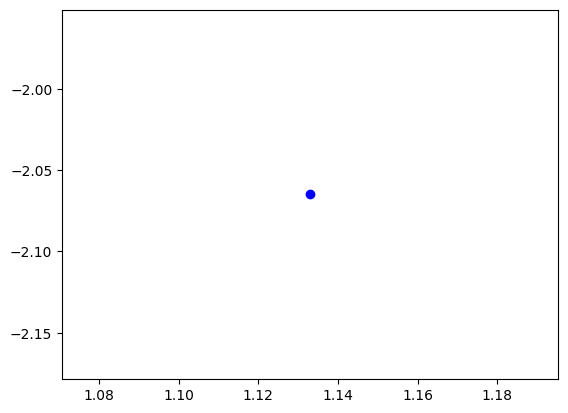

In [24]:
def plot_path(configurations, rho):
    fig, ax = plt.subplots()
    points = np.array([q[0] for q in configurations])
    angles = np.array([q[1] for q in configurations])

    for i, ((x, y), angle) in enumerate(configurations):
        ax.plot(x, y, 'bo')
        ax.arrow(x, y, 0.5 * np.cos(angle), 0.5 * np.sin(angle), head_width=0.1, head_length=0.2, fc='k', ec='k')
        
    for i in range(len(points)):
        start = points[i]
        end = points[(i + 1) % len(points)]
        # Aqui, você deve adicionar a lógica para desenhar a curva de Dubins entre start e end
        # Vamos desenhar uma linha reta simplificada para esta demonstração
        ax.plot([start[0], end[0]], [start[1], end[1]], 'r-')

    ax.set_aspect('equal', 'box')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Dubins Traveling Salesman Path')
    plt.show()

# Parâmetros do problema
num_points = 10
min_turn_radius = 10
curvature = 1.0


# points = [
#     [1.0, 1.0], 
#     [-3.0, -3.0],
#     [2.0, 2.0],
#     [-2.0, -1.0]
#     # Adicione mais pontos conforme necessário
# ]

points = [
    [+1.133, -2.065], 
    [+1.133, +1.412],
    [-1.541, +1.412],
    [-1.541, -1.863]
    # Adicione mais pontos conforme necessário
]
points = np.array(points)
# print(type(points))

# Solução DTSP
# dubins_points, total_length = dubins_tsp(points, min_turn_radius)
dubins_points = dtsp(points, curvature)
print(dubins_points)

# Plot da solução
plot_path(dubins_points, curvature)

print("Comprimento total da trajetória:", total_length)



In [ ]:
# TESTE 1 
# start_x = -4.0  # [m]
# start_y = -4.0  # [m]
# start_yaw = np.deg2rad(45.0)  # [rad]

# end_x = -2.5  # [m]
# end_y = -0.5  # [m]
# end_yaw = np.deg2rad(-45.0)  # [rad]

#TESTE 2
# start_x = -4.0  # [m]
# start_y = -4.0  # [m]
# start_yaw = np.deg2rad(45.0)  # [rad]

# end_x = +2.5  # [m]
# end_y = -2.5  # [m]
# end_yaw = np.deg2rad(-45.0)  # [rad]

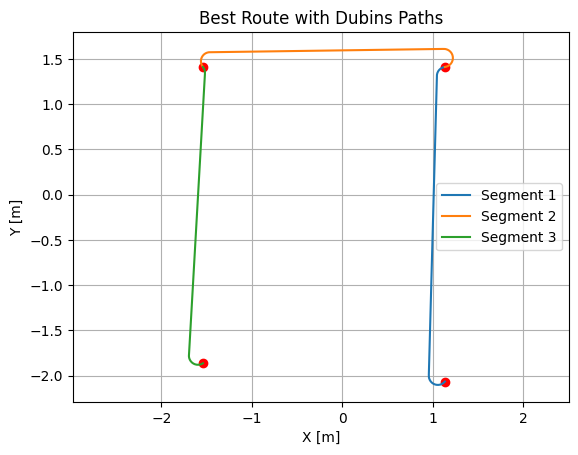

In [ ]:
curvature = 10.0

plt.figure()
for i in range(len(dubins_points)-1):
    s_x, s_y, s_yaw = dubins_points[i]
    e_x, e_y, e_yaw = dubins_points[i + 1]

    path_x, path_y, path_yaw, mode, lengths = plan_dubins_path(s_x,
                                                            s_y,
                                                            s_yaw,
                                                            e_x,
                                                            e_y,
                                                            e_yaw,
                                                            curvature)
    plt.plot(path_x, path_y, label=f"Segment {i+1}")
plt.scatter([p[0] for p in dubins_points], [p[1] for p in dubins_points], color='red')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Best Route with Dubins Paths')
plt.legend()
plt.grid(True)
plt.axis("equal")
plt.show()

# path_x, path_y, path_yaw, mode, lengths = plan_dubins_path(start_x,
#                                                             start_y,
#                                                             start_yaw,
#                                                             end_x,
#                                                             end_y,
#                                                             end_yaw,
#                                                             curvature)


# plt.plot(path_x, path_y, label="".join(mode))
# plot_arrow(start_x, start_y, start_yaw)
# plot_arrow(end_x, end_y, end_yaw)
# plt.legend()
# plt.grid(True)
# plt.axis("equal")
# plt.show()

### INIT

In [ ]:
# ---------------------------------------------- Init ----------------------------------------
try:
    client = RemoteAPIClient()
    sim = client.require('sim')
except:
    print('Error connection')

### Constantes

In [ ]:
#Informações do Robô
L = 0.230
R = 0.035
ROBOT = "kobuki"
maxv = 1.0
maxw = np.deg2rad(45)

#Handles
objectHandle_RP = sim.getObject("/" + ROBOT)
robotHandle = sim.getObject("/" + ROBOT)  
robotLeftMotorHandle = sim.getObject("/" +'kobuki_leftMotor')
robotRightMotorHandle = sim.getObject("/" +'kobuki_rightMotor')


### Controle

https://chatgpt.com/share/0b73c8b3-3aa8-46cf-b90a-b7baec7dae14
Para implementar um controlador que permita ao seu robô percorrer um caminho utilizando curvas de Dubins, o controle de pose é o mais indicado. Isso se deve às seguintes razões:

Precisão na Orientação: As curvas de Dubins são caracterizadas por segmentos de linha reta e segmentos de arco de círculo, que requerem que o robô ajuste sua orientação de forma precisa ao longo do caminho.
Transições Suaves: O controle de pose permite transições suaves entre diferentes segmentos da curva, garantindo que o robô siga o caminho de maneira mais natural e precisa.
Correção de Trajetória: O controle de pose pode lidar melhor com a correção de trajetória quando o robô se desvia ligeiramente do caminho ideal, ajustando tanto a posição quanto a orientação para realinhar o robô.

In [ ]:
# Normalize angle to the range [-pi,pi)
def normalizeAngle(angle):
    return np.mod(angle + np.pi, 2 * np.pi) - np.pi

sim.startSimulation()
dubins_list = list(dubins_points)
start = dubins_list[0]
qstart = [start[0], start[1], 0]
print(dubins_list[0])
sim.setObjectPosition(robotHandle, qstart)

robot_path = []

for i in range(len(dubins_points)-1):
    dubins_path = []
    s_x, s_y, s_yaw = dubins_points[i]
    e_x, e_y, e_yaw = dubins_points[i + 1]

    path_x, path_y, path_yaw, mode, lengths = plan_dubins_path(s_x,
                                                            s_y,
                                                            s_yaw,
                                                            e_x,
                                                            e_y,
                                                            e_yaw,
                                                            curvature)

    for x, y, angle in zip(path_x, path_y, path_yaw):
        dubins_path.append(np.array([x,y,angle]))

    for qgoal in dubins_path:
        rho = np.inf
        while rho > 0.05:
            #Configuração do robo
            robotPos = sim.getObjectPosition(robotHandle, sim.handle_world)   
            robotOri = sim.getObjectOrientation(objectHandle_RP, 
                                                    sim.handle_world)
            robotConfig = np.array([robotPos[0], robotPos[1], robotOri[2]])

            robotPos = robotPos[0:2]
            robot_path.append(robotPos)

            dx, dy, dth = qgoal - robotConfig

            rho = np.sqrt(dx**2 + dy**2)
            alpha = normalizeAngle(-robotConfig[2] + np.arctan2(dy, dx))
            beta = normalizeAngle(qgoal[2] - np.arctan2(dy, dx))

            kr = 4 / 20
            ka = 8 / 20
            kb = -1.5 / 20

            if abs(alpha) > np.pi/2:
                kr = -kr       
                alpha = normalizeAngle(alpha - np.pi)
                beta = normalizeAngle(beta - np.pi)

            v = kr * rho
            w = ka * alpha + kb * beta

            v = max(min(v, maxv), -maxv)
            w = max(min(w, maxw), -maxw)

            wr = ((2.0 * v) + (w * L)) / (2.0 * R)
            wl = ((2.0 * v) - (w * L)) / (2.0 * R)

            sim.setJointTargetVelocity(robotRightMotorHandle, wr)
            sim.setJointTargetVelocity(robotLeftMotorHandle, wl)

sim.setJointTargetVelocity(robotRightMotorHandle, 0)
sim.setJointTargetVelocity(robotLeftMotorHandle, 0)

sim.stopSimulation()

[ 1.133     -2.065     16.5997214]


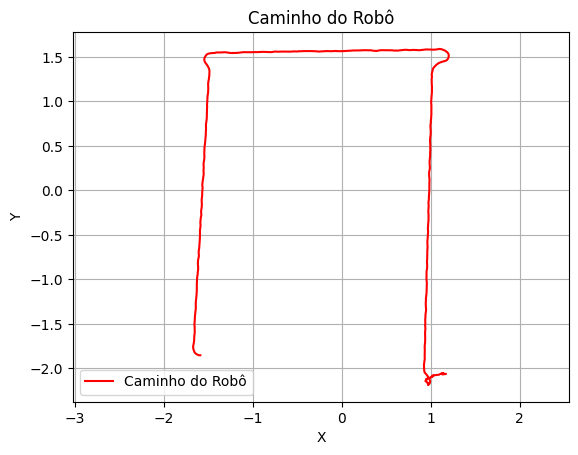

In [ ]:
robot_path = np.array(robot_path)
plt.plot(robot_path[:, 0], robot_path[:, 1], '-r', label='Caminho do Robô')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Caminho do Robô')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.savefig("robot_path_and_obstacles.png")
plt.show()